In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [2]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

In [3]:
weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


In [4]:
for num in range(data.shape[1]):
    data.iloc[:,num] = data.iloc[:,num].interpolate(method='linear')
    print(sum(np.isnan(x) for x in data.iloc[:,num]))

0
0
0
0
0
0
0


In [5]:
from pandas import DataFrame, concat
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import MinMaxScaler
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data.values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 10, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[71,72,73,74,75,76]], axis=1, inplace=True)
reframed.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var1(t-9),var2(t-9),var3(t-9),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
10,0.046511,0.666667,0.000000,0.666667,0.339286,0.342949,0.772727,0.042250,0.666667,0.000000,...,0.317308,0.738636,0.043304,0.666667,0.086957,0.666667,0.321429,0.317308,0.738636,0.045303
11,0.042250,0.666667,0.000000,0.666667,0.339286,0.342949,0.772727,0.041445,0.666667,0.000000,...,0.317308,0.738636,0.045303,0.666667,0.086957,0.666667,0.321429,0.317308,0.738636,0.046774
12,0.041445,0.666667,0.000000,0.666667,0.339286,0.342949,0.772727,0.046636,0.666667,0.043478,...,0.317308,0.738636,0.046774,0.666667,0.130435,0.666667,0.321429,0.317308,0.738636,0.043971
13,0.046636,0.666667,0.043478,0.666667,0.339286,0.333333,0.738636,0.045844,0.666667,0.043478,...,0.317308,0.738636,0.043971,0.666667,0.130435,0.666667,0.321429,0.317308,0.738636,0.042250
14,0.045844,0.666667,0.043478,0.666667,0.339286,0.333333,0.738636,0.041583,0.666667,0.043478,...,0.317308,0.738636,0.042250,0.666667,0.130435,0.666667,0.321429,0.317308,0.738636,0.043582


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = len(values)-96
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35029, 1, 70) (35029,) (96, 1, 70) (96,)


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(70, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=int(train.shape[0]/96), validation_data=(test_X, test_y), verbose=1, shuffle=False)

Using TensorFlow backend.


Train on 35029 samples, validate on 96 samples
Epoch 1/50
35029/35029 [==============================] - 2s 65us/step - loss: 0.0064 - val_loss: 0.0028
Epoch 2/50
35029/35029 [==============================] - 1s 28us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 3/50
35029/35029 [==============================] - 1s 24us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
35029/35029 [==============================] - 1s 24us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/50
35029/35029 [==============================] - 1s 26us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/50
35029/35029 [==============================] - 1s 27us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/50
35029/35029 [==============================] - 1s 25us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/50
35029/35029 [==============================] - 1s 25us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
35029/35029 [==============================] - 1s 23us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10

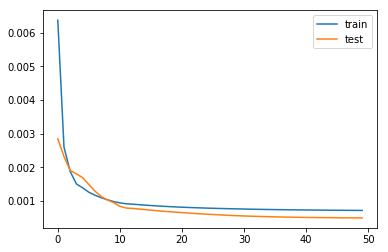

In [8]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 2.577


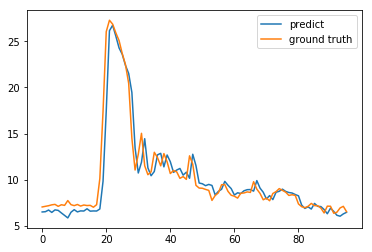

In [10]:
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='ground truth')
pyplot.legend()
pyplot.show()

In [16]:
model.save('LSTM_10lag.h5')

# Testing Saved Model

In [11]:
from keras.models import load_model
model_maybe = load_model('LSTM_10lag.h5')

In [13]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# split into train and test sets
values = reframed.values
n_train_hours = len(values)-96
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# make a prediction
yhat = model_maybe.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 2.504


# Test a different LSTM on 5129 future points (to confirm LSTM's robustness)

(30000, 1, 70) (30000,) (5125, 1, 70) (5125,)
Train on 30000 samples, validate on 5125 samples
Epoch 1/50
30000/30000 [==============================] - 2s 69us/step - loss: 0.0049 - val_loss: 0.0039
Epoch 2/50
30000/30000 [==============================] - 1s 29us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 3/50
30000/30000 [==============================] - 1s 28us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/50
30000/30000 [==============================] - 1s 28us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/50
30000/30000 [==============================] - 1s 29us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
30000/30000 [==============================] - 1s 28us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
30000/30000 [==============================] - 1s 29us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
30000/30000 [==============================] - 1s 28us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/50
30000/30000 [==============================] - 1s 28us

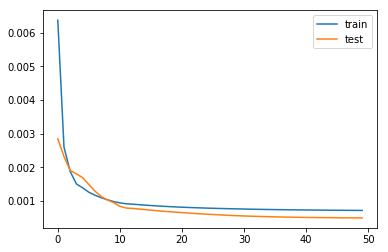

Test MSE: 4.263


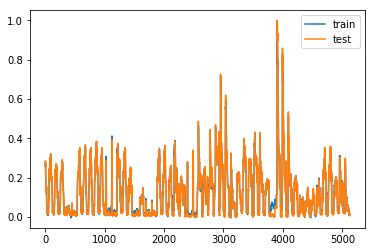

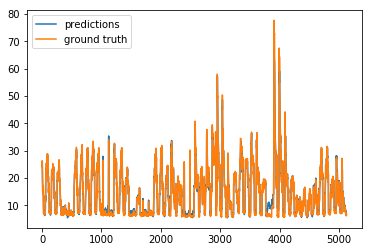

In [14]:
# split into train and test sets
values = reframed.values
n_train_hours = 30000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design network
model2 = Sequential()
model2.add(LSTM(70, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history3 = model2.fit(train_X, train_y, epochs=50, batch_size=int(train.shape[0]/96), validation_data=(test_X, test_y), verbose=1, shuffle=False)

from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model2.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

pyplot.figure()
pyplot.plot(inv_yhat, label='predictions')
pyplot.plot(inv_y, label='ground truth')
pyplot.legend()
pyplot.show()